# Setup

In [9]:
# Imports

import polars as pl
import duckdb
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt

In [10]:
# Paths
project_dir = Path("/data/teamgdansk/mwaleron/carmen-analysis")

data_dir = project_dir.joinpath("data")
figures_dir = project_dir.joinpath("figures")
temp_dir = project_dir.joinpath("temp")

db_main_file = data_dir.joinpath("carmen-main.parquet")

figures_gen_dir = figures_dir.joinpath("script-generated")
fig5panelz = figures_gen_dir.joinpath("Contigs-3dscatterplot-log-scales.png")
fig5panely = figures_gen_dir.joinpath("fig5panely")
fig5panelx = figures_gen_dir.joinpath("UMAP_PBRM1_VHL.pdf")
fig5panelw1 = figures_gen_dir.joinpath("high_population_example.pdf")
fig5panelw2 = figures_gen_dir.joinpath("mid_population_example.pdf")
fig5panelw3 = figures_gen_dir.joinpath("mid_population_example_2.pdf")
fig5panelw4 = figures_gen_dir.joinpath("mid_population_example_3.pdf")
fig5panelw5 = figures_gen_dir.joinpath("low_population_example.pdf")

figures_main_dir = figures_gen_dir.joinpath("main-panels")
figures_supp_dir = figures_gen_dir.joinpath("supplementary")

data_subs_dir = data_dir.joinpath("subsidiary-files")
data_pub_dir = data_dir.joinpath("to-be-published")

cosmic_data_dir = data_subs_dir.joinpath("COSMIC")
cosmic_genome_screening_file = cosmic_data_dir.joinpath("Cosmic_GenomeScreensMutant_v99_GRCh38.tsv")
cosmic_classification_file = cosmic_data_dir.joinpath("Cosmic_Classification_v99_GRCh38.tsv")

oncokb_list_file = data_subs_dir.joinpath("cancerGeneList.tsv")
braun_dataset_mut = data_subs_dir.joinpath("Braun_mutations_hg38_with_epitope_contigs.tsv")

gendode_data_dir = data_subs_dir.joinpath("GENCODE")
gencodev39_stripped = gendode_data_dir.joinpath("gencode.v39.annotation.stripped.versions.parquet")
gene_stats_file = data_subs_dir.joinpath("per_gene_stats.parquet")

pogo_annotations_file = data_dir.joinpath("carmen-mapped-protein-annotations-pogo.parquet")
peptides_per_hla_file = data_subs_dir.joinpath("peptides-per-hla.csv")
contig_scaffold_list_file = data_pub_dir.joinpath("scaff_all_expanded.tsv")
contig_peptide_list_file = data_pub_dir.joinpath("contig_unique_peptide_list.tsv")
contig_hotspot_score_file = data_subs_dir.joinpath("sorted_normalized_contig_score.parquet")
contig_intersection_with_genes_file = data_subs_dir.joinpath("join_of_contigs_scaffolds_and_genes.parquet")

exon_ranges_in_contigs_file = data_subs_dir.joinpath("evenbiggerjoin_cause_its_exons_not_just_genes_v2_just_the_contig_genes.parquet")

cosmic_somatics_overlap_with_contigs_file = data_subs_dir.joinpath("cosmic_somatics_overlap_with_contigs.parquet")
cosmic_somatics_overlap_with_top_quadrant_file = data_subs_dir.joinpath("cosmic_somatics_overlap_with_tq.parquet")
cosmic_mutations_in_contigs_semi_anti_file_B = data_subs_dir.joinpath("contig_cosmic_mutations.parquet")
cosmic_mutations_in_contigs_semi_anti_file_B_compliment = data_subs_dir.joinpath("non_contig_cosmic_mutations.parquet")
cosmic_mutations_in_top_quadrant_semi_anti_file_B = data_subs_dir.joinpath("tq_cosmic_mutations.parquet")
cosmic_mutations_in_top_quadrant_semi_anti_file_B_compliment = data_subs_dir.joinpath("non_tq_cosmic_mutations.parquet")

main_samples_file = data_dir.joinpath("main-output-table-1.tsv")
main_samples_file_2 = data_dir.joinpath("main-output-table-2.tsv")
main_samples_file_3 = data_subs_dir.joinpath("emilia_umap_with_ids.parquet")

Dump this somewhere below

In [11]:
main = pl.scan_parquet(db_main_file)

In [12]:
samplewise = pl.read_parquet("/data/teamgdansk/carmen-peptide-clusters-characteristics_with_promiscuity.parquet")

In [13]:
samplewise = samplewise.sort("Promiscuity")

# Panel A top half

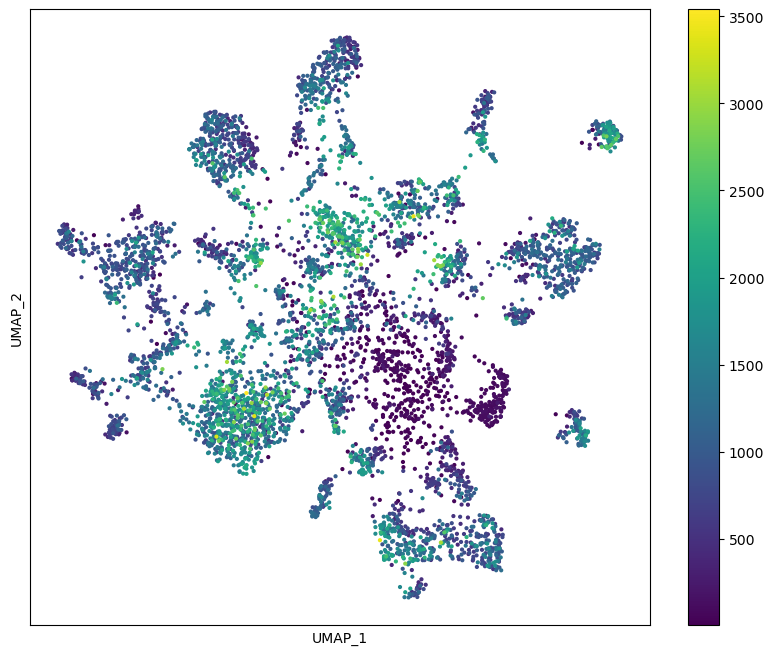

In [14]:
fig = plt.figure(figsize=(10,8))
minimum_match = 1
ax1 = plt.subplot(111)
sm = ax1.scatter(samplewise['UMAP_x'], samplewise['UMAP_y'], c=samplewise['Promiscuity'], s=4, label='Unmatched')
ax1.set_xlabel("UMAP_1")
ax1.set_ylabel("UMAP_2")
ax1.set_xticklabels("")
ax1.set_yticklabels("")
ax1.set_xticks([])
ax1.set_yticks([])
plt.colorbar(sm)
fig.show()
#fig.savefig("Cluster_map_colored_by_promiscuity.pdf")
#fig.savefig(fig5panelxxx)

# Panel A bottom half

In [19]:
def plot_motif_space_for_a_list_of_peptides_subplot(list_of_peptides, match_color = 'orange', mismatch_color= 'blue', minimum_match = 1, title_header = ""):
    from scipy.spatial import ConvexHull

    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.rcParams["svg.fonttype"] = "none"
    emilia_umap_with_ids = pl.read_parquet(main_samples_file_3)
    motif_peptide_size = emilia_umap_with_ids\
                                .explode(
                                    "Peptides"
                                ).group_by(
                                    "Id"
                                ).count().rename({"count":"motif_size"})
    matchcount_per_motif =  emilia_umap_with_ids\
                                .explode(
                                    "Peptides"
                                ).with_columns(
                                    pl.col("Peptides").is_in(list_of_peptides).cast(pl.Int64())
                                ).group_by(
                                    "Id"
                                ).sum(
                                ).select(
                                    pl.col("Id"), pl.col("Peptides").alias("Number_of_matches")
                                ).join(motif_peptide_size, on="Id")
    plot_material = emilia_umap_with_ids\
                        .join(matchcount_per_motif, on="Id")
    if minimum_match >= 1:
        matches = plot_material.filter(pl.col("Number_of_matches")>=minimum_match)
        mismatches = plot_material.filter(pl.col("Number_of_matches")<minimum_match)
    elif 1.0 > minimum_match > 0.0:
        matches = plot_material.filter(pl.col("Number_of_matches")>=minimum_match * pl.col("motif_size"))
        mismatches = plot_material.filter(pl.col("Number_of_matches")<minimum_match * pl.col("motif_size"))
    else:
        return "That aint a correct minimal match numer or fraction"
    
    xallcen = (emilia_umap_with_ids["x"].min() + emilia_umap_with_ids["x"].max() )/2
    yallcen = (emilia_umap_with_ids["y"].min() + emilia_umap_with_ids["y"].max() )/2
    match_x = matches["x"].sum() / matches["x"].len()
    match_y = matches["y"].sum() / matches["y"].len()
    vlen = math.sqrt((match_x - xallcen) ** 2 + (match_y - yallcen) ** 2)
    listscore = len(matches) / math.sqrt(1+vlen)

    ax212 = plt.subplot(122)
    ax212.scatter(mismatches["x"], mismatches["y"], c=mismatch_color, s=4)
    ax212.scatter(matches["x"], matches["y"], c=match_color, s=4)
    ax212.set_title(f"{len(list_of_peptides)} unique peptides\n{listscore:.2f} population coverage score")
    ax212.set_xlabel("UMAP_1")
    ax212.set_ylabel("UMAP_2")
    ax212.set_xticklabels("")
    ax212.set_yticklabels("")
    ax212.set_xticks([])
    ax212.set_yticks([])
    ax212.axvline(xallcen)
    ax212.axhline(yallcen)
    
    ch = matches.select(pl.col("x"), pl.col("y")).to_numpy()
    hull = ConvexHull(ch)
    for simplex in hull.simplices:
        ax212.plot(matches[simplex]["x"],matches[simplex]["y"], c='tab:red')
    ax212.annotate(
        "",
        xy=(match_x,match_y),
        xytext=(xallcen,yallcen),
        arrowprops=dict(
            arrowstyle="->",
            patchA=None,
            patchB=None,
            shrinkA=0,
            shrinkB=0,
            linewidth=3,
            color="tab:red"
        ))
    return ax212

/tmp/ipykernel_3149325/3476898175.py:8: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\


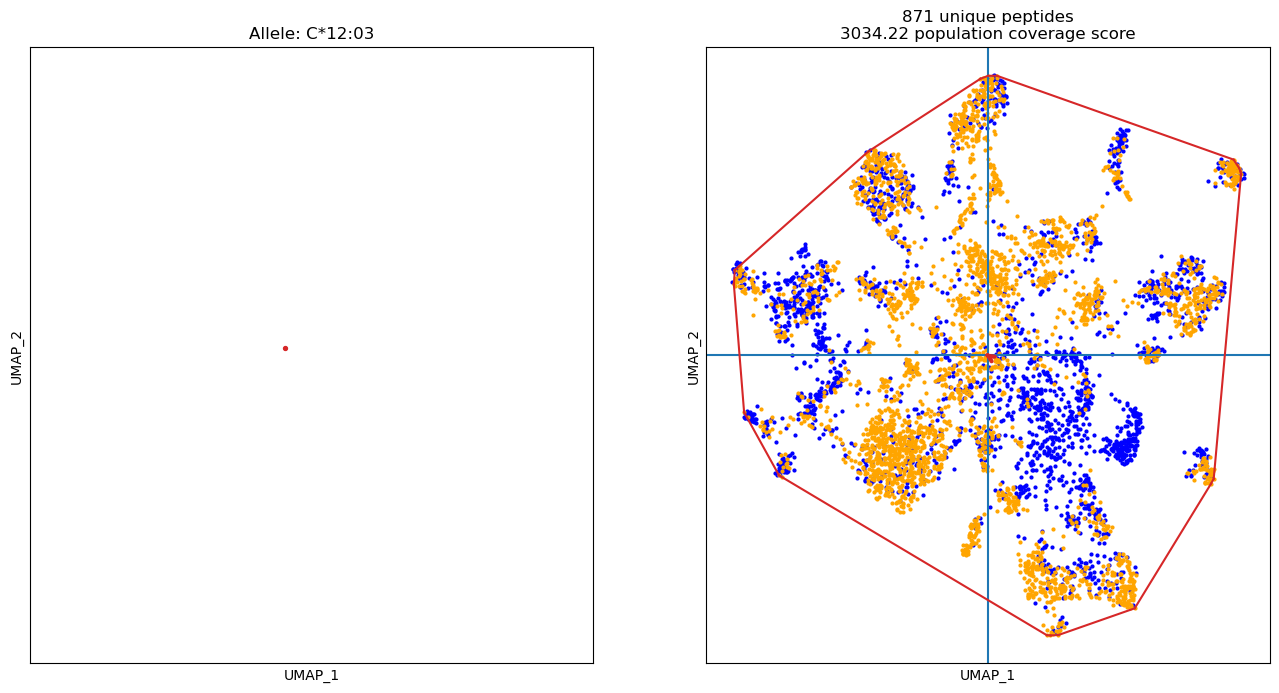

In [20]:
for sample in samplewise.with_columns(monoallelic = pl.col("Binding_alleles").str.split(";").list.len()==1).filter("monoallelic").tail(1).iter_rows(named=True):
    fig = plt.figure(figsize=(16,8))
    minimum_match = 1
    ax2 = plot_motif_space_for_a_list_of_peptides_subplot(sample["Peptides"].split(";"))
    ax1 = plt.subplot(121)
    ax1.scatter(sample['UMAP_x'], sample['UMAP_y'], c='tab:red', s=8, label='Unmatched')
    ax1.set_xlabel("UMAP_1")
    ax1.set_ylabel("UMAP_2")
    ax1.set_xlim(ax2.get_xlim())
    ax1.set_ylim(ax2.get_ylim())
    ax1.set_xscale(ax2.get_xscale())
    ax1.set_yscale(ax2.get_yscale())
    ax1.set_title(f"Allele: {sample['Binding_alleles']}")
    ax1.set_xticklabels("")
    ax1.set_yticklabels("")
    ax1.set_xticks([])
    ax1.set_yticks([])
    fig.show()
#    fig.savefig("C1203_promiscuous_monoallelic_cluster.pdf")

# Panel b and c

In [29]:
test = samplewise.filter(pl.col("Binding_alleles").str.contains("A*24:02")).filter(pl.col("UMAP_x") < -1.187, pl.col("UMAP_y") > 8.138)

In [30]:
test

ID,Sample_name,Peptides,Binding_alleles,UMAP_x,UMAP_y,Label,Freq_AAFA_A,Freq_AFB_A,Freq_AINDI_A,Freq_AISC_A,Freq_ALANAM_A,Freq_AMIND_A,Freq_CARB_A,Freq_CARHIS_A,Freq_CARIBI_A,Freq_EURCAU_A,Freq_FILII_A,Freq_HAWI_A,Freq_JAPI_A,Freq_KORI_A,Freq_MENAFC_A,Freq_MSWHIS_A,Freq_NCHI_A,Freq_SCAHIS_A,Freq_SCAMB_A,Freq_SCSEAI_A,Freq_VIET_A,Freq_AAFA_B,Freq_AFB_B,Freq_AINDI_B,Freq_AISC_B,Freq_ALANAM_B,Freq_AMIND_B,Freq_CARB_B,Freq_CARHIS_B,Freq_CARIBI_B,…,Freq_CARB_ABC_any,Freq_CARHIS_ABC_any,Freq_CARIBI_ABC_any,Freq_EURCAU_ABC_any,Freq_FILII_ABC_any,Freq_HAWI_ABC_any,Freq_JAPI_ABC_any,Freq_KORI_ABC_any,Freq_MENAFC_ABC_any,Freq_MSWHIS_ABC_any,Freq_NCHI_ABC_any,Freq_SCAHIS_ABC_any,Freq_SCAMB_ABC_any,Freq_SCSEAI_ABC_any,Freq_VIET_ABC_any,Freq_AAFA_ABC_all,Freq_AFB_ABC_all,Freq_AINDI_ABC_all,Freq_AISC_ABC_all,Freq_ALANAM_ABC_all,Freq_AMIND_ABC_all,Freq_CARB_ABC_all,Freq_CARHIS_ABC_all,Freq_CARIBI_ABC_all,Freq_EURCAU_ABC_all,Freq_FILII_ABC_all,Freq_HAWI_ABC_all,Freq_JAPI_ABC_all,Freq_KORI_ABC_all,Freq_MENAFC_ABC_all,Freq_MSWHIS_ABC_all,Freq_NCHI_ABC_all,Freq_SCAHIS_ABC_all,Freq_SCAMB_ABC_all,Freq_SCSEAI_ABC_all,Freq_VIET_ABC_all,Promiscuity
str,str,str,str,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""P_3158""","""sample_PXD025345_191216PK_1954…","""AYLEAIHNF;AYLESFYKF;AYLPPLQQVF…","""A*24:02;B*35:01;B*40:06;C*04:0…",-1.741656,10.359104,8,0.024539,0.022007,0.136224,0.112176,0.229045,0.129202,0.02508,0.093852,0.095486,0.084645,0.239867,0.239301,0.352955,0.221082,0.11743,0.130368,0.15188,0.131626,0.060845,0.138026,0.110938,0.069284,0.067218,0.153634,0.085166,0.088181,0.098527,0.076374,0.048757,0.054173,…,0.269001,0.262243,0.271165,0.200366,0.421835,0.400106,0.490411,0.345728,0.292559,0.309506,0.231862,0.318837,0.272063,0.309666,0.172505,0.001392,0.001234,0.022512,0.015615,0.020198,0.02135,0.001705,0.002274,0.003173,0.00422,0.006763,0.001813,0.001159,0.001564,0.007345,0.011247,0.000402,0.009475,0.005356,0.015926,0.000291,184.693071
"""P_5016""","""sample_colon_W6_006""","""AYIQEFQEF;AYLEAIHNF;AYLESFYKF;…","""A*03:01;A*24:02;B*35:03;B*45:0…",-1.932783,10.186661,13,0.108486,0.100348,0.199803,0.218188,0.305717,0.233565,0.103327,0.180158,0.17653,0.224511,0.252959,0.271587,0.361928,0.240134,0.218406,0.211834,0.165893,0.205465,0.145338,0.187893,0.120669,0.051522,0.046027,0.072846,0.019821,0.0139,0.015777,0.048345,0.050024,0.05549,…,0.405388,0.383754,0.378527,0.334005,0.38426,0.384778,0.393456,0.283535,0.35748,0.389352,0.204873,0.39126,0.411528,0.280932,0.154924,0.003706,0.002991,0.008941,0.004614,0.001467,0.002439,0.004123,0.00636,0.007075,0.004413,0.00141,0.004816,0.000102,0.000366,0.008619,0.005822,0.000854,0.006322,0.003023,0.008034,0.000483,193.699281
"""P_4883""","""sample_bladder_W6_010""","""AYAIITALL;AYGNVFSAF;AYLEAIHNF;…","""A*24:02;A*30:01;B*13:02;B*35:0…",-1.959826,10.218481,13,0.093024,0.090511,0.153542,0.125835,0.237887,0.140116,0.09707,0.123223,0.125473,0.09763,0.244333,0.242194,0.354826,0.252772,0.14573,0.146607,0.179307,0.151507,0.115599,0.154938,0.124822,0.008211,0.013203,0.020449,0.019729,0.016013,0.017887,0.008627,0.012948,0.011703,…,0.37827,0.317314,0.325202,0.270042,0.383785,0.377708,0.39377,0.320495,0.365335,0.340135,0.232261,0.348554,0.369041,0.340401,0.194216,0.001955,0.001654,0.014555,0.007347,0.00507,0.007498,0.001662,0.005363,0.004263,0.012239,0.003713,0.001995,0.001774,0.028592,0.021533,0.008725,0.024927,0.008216,0.003083,0.014453,0.004773,224.770179
"""P_3985""","""sample_PXD027182_NB8_PASEGA_0B…","""DAADIVFLI;KALEVFPEF;KFIDTTSKF;…","""A*02:01;A*24:02;B*51:01:01;B*5…",-1.653981,9.974231,8,0.147999,0.136585,0.185406,0.376842,0.421279,0.406851,0.135796,0.262293,0.240975,0.360152,0.306988,0.359062,0.500949,0.406834,0.314709,0.353413,0.246513,0.341084,0.198362,0.195764,0.145874,0.028786,0.029

In [24]:
test2 = pl.read_csv("/data/teamgdansk/main-embeddings_MHCMotifA_pssms.tsv", separator="\t")

In [26]:
def plot_motif_space_for_a_list_of_peptides_subplot(axis, list_of_peptides, match_color = 'tab:orange', mismatch_color= 'tab:blue', minimum_match = 1, title_header = ""):
    from scipy.spatial import ConvexHull

    emilia_umap_with_ids = pl.read_parquet(main_samples_file_3)
    motif_peptide_size = emilia_umap_with_ids\
                                .explode(
                                    "Peptides"
                                ).group_by(
                                    "Id"
                                ).count().rename({"count":"motif_size"})
    matchcount_per_motif =  emilia_umap_with_ids\
                                .explode(
                                    "Peptides"
                                ).with_columns(
                                    pl.col("Peptides").is_in(list_of_peptides).cast(pl.Int64())
                                ).group_by(
                                    "Id"
                                ).sum(
                                ).select(
                                    pl.col("Id"), pl.col("Peptides").alias("Number_of_matches")
                                ).join(motif_peptide_size, on="Id")
    plot_material = emilia_umap_with_ids\
                        .join(matchcount_per_motif, on="Id")
    if minimum_match >= 1:
        matches = plot_material.filter(pl.col("Number_of_matches")>=minimum_match)
        mismatches = plot_material.filter(pl.col("Number_of_matches")<minimum_match)
    elif 1.0 > minimum_match > 0.0:
        matches = plot_material.filter(pl.col("Number_of_matches")>=minimum_match * pl.col("motif_size"))
        mismatches = plot_material.filter(pl.col("Number_of_matches")<minimum_match * pl.col("motif_size"))
    else:
        return "That aint a correct minimal match numer or fraction"
    
    xallcen = (emilia_umap_with_ids["x"].min() + emilia_umap_with_ids["x"].max() )/2
    yallcen = (emilia_umap_with_ids["y"].min() + emilia_umap_with_ids["y"].max() )/2
    match_x = matches["x"].sum() / matches["x"].len()
    match_y = matches["y"].sum() / matches["y"].len()
    vlen = math.sqrt((match_x - xallcen) ** 2 + (match_y - yallcen) ** 2)
    listscore = len(matches) / math.sqrt(1+vlen)

    axis.scatter(mismatches["x"], mismatches["y"], c=mismatch_color, s=4)
    axis.scatter(matches["x"], matches["y"], c=match_color, s=4)
    axis.set_title(f"{len(list_of_peptides)} unique peptides\n{listscore:.2f} population coverage score\n{title_header}")
    axis.set_xlabel("UMAP_1")
    axis.set_ylabel("UMAP_2")
    axis.set_xticklabels("")
    axis.set_yticklabels("")
    axis.set_xticks([])
    axis.set_yticks([])
    axis.axvline(xallcen)
    axis.axhline(yallcen)
    
    ch = matches.select(pl.col("x"), pl.col("y")).to_numpy()
    hull = ConvexHull(ch)
    for simplex in hull.simplices:
        axis.plot(matches[simplex]["x"],matches[simplex]["y"], c='tab:red')
    axis.annotate(
        "",
        xy=(match_x,match_y),
        xytext=(xallcen,yallcen),
        arrowprops=dict(
            arrowstyle="->",
            patchA=None,
            patchB=None,
            shrinkA=0,
            shrinkB=0,
            linewidth=3,
            color="tab:red"
        ))
    return axis

/tmp/ipykernel_3149325/1592895696.py:5: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\
/tmp/ipykernel_3149325/1592895696.py:5: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\
/tmp/ipykernel_3149325/1592895696.py:5: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\
/tmp/ipykernel_3149325/1592895696.py:5: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\
/tmp/ipykernel_3149325/1592895696.py:5: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\
/tmp/ipykernel_3149325/1592895696.py:5: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  motif_peptide_size = emilia_umap_with_ids\


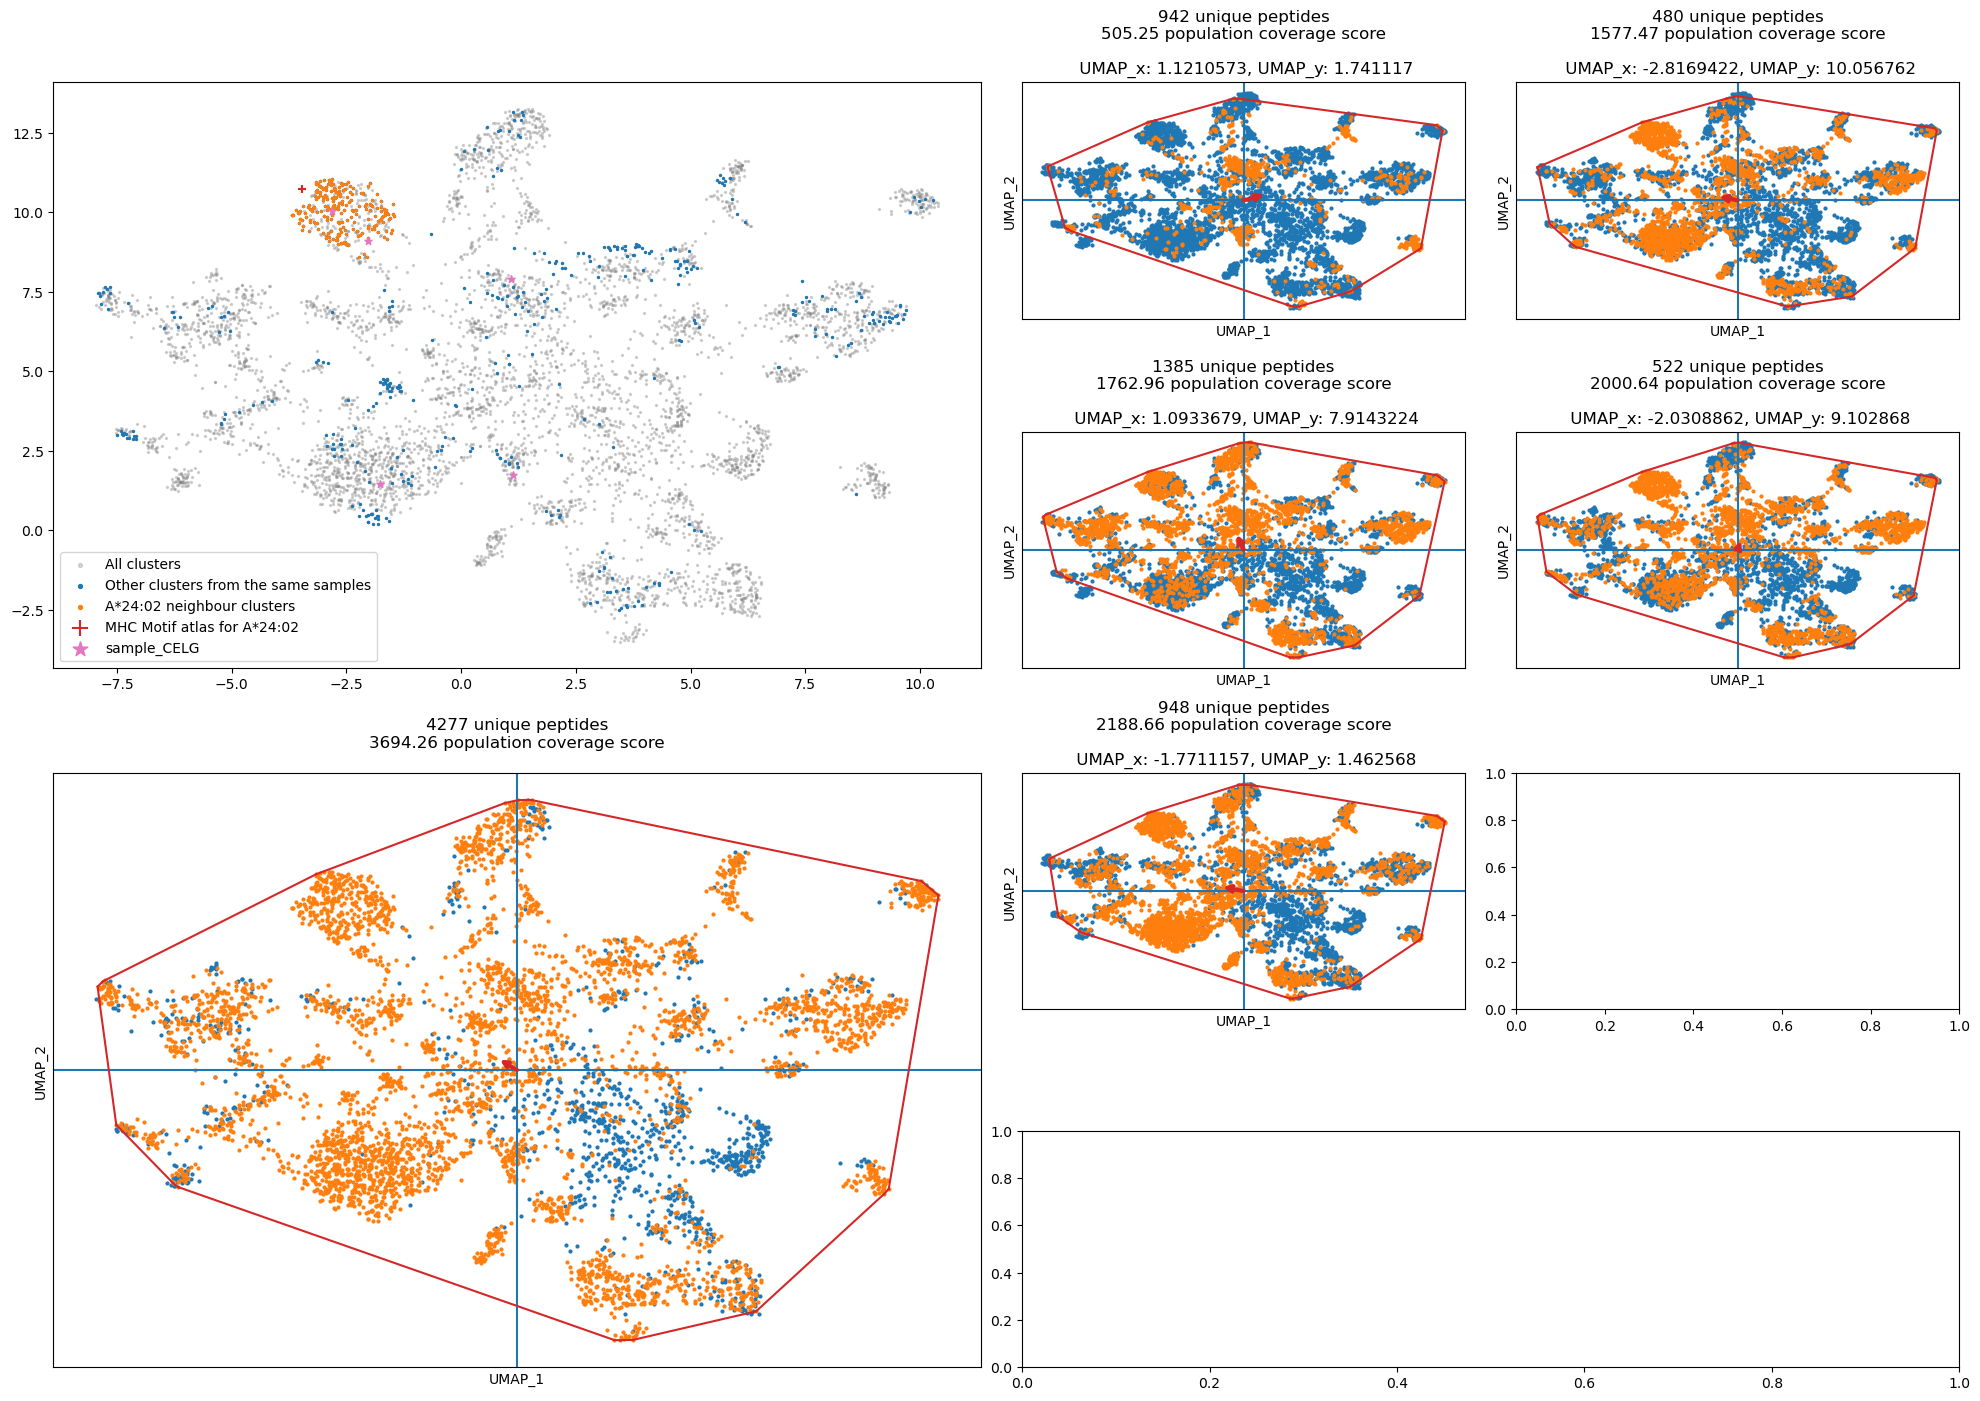

In [31]:
from textwrap import wrap
from matplotlib.backends.backend_pdf import PdfPages

mm=1/25.4
sample = "sample_CELG"

fig = plt.figure(figsize=(500*mm,353*mm), 
        layout="constrained")
        
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
axes = fig.subplot_mosaic(
    [
        ["pop", "pop", "cluster1", "cluster2"],
        ["pop", "pop", "cluster3", "cluster4"],
        ["sample", "sample", "cluster5", "cluster6"],
        ["sample", "sample", "lorem", "lorem"]
    ],
)

axes["pop"].scatter(samplewise["UMAP_x"], samplewise["UMAP_y"], c="tab:gray", alpha=0.3, label = "All clusters", s=2)
other_clusters = samplewise.filter(pl.col("Sample_name").is_in(test["Sample_name"]))
axes["pop"].scatter(other_clusters["UMAP_x"], other_clusters["UMAP_y"], c="tab:blue", s=2, label="Other clusters from the same samples")#c=cm.prism(other_clusters["Binding_alleles"].cast(pl.Categorical()).to_physical()), s=2)
axes["pop"].scatter(test["UMAP_x"], test["UMAP_y"], c="tab:orange", label="A*24:02 neighbour clusters", s=2)
axes["pop"].scatter(test2.filter(pl.col("Allele")=="A2402")["0"], test2.filter(pl.col("Allele")=="A2402")["1"], c="tab:red", marker="+", label="MHC Motif atlas for A*24:02")
this_sample = samplewise.filter(pl.col("Sample_name")==sample)
axes["pop"].scatter(this_sample["UMAP_x"], this_sample["UMAP_y"], c="tab:pink", s=30, marker="*", label=sample)
axes["pop"].legend(markerscale=2)
        
all_sample_peptides = samplewise.filter(pl.col("Sample_name")==sample).select(pl.col("Peptides").str.split(";").explode().unique())
plot_motif_space_for_a_list_of_peptides_subplot(axes["sample"], all_sample_peptides)
        
index = 1
for cluster in this_sample.iter_rows(named=True):
    plot_motif_space_for_a_list_of_peptides_subplot(axes[f"cluster{index}"], cluster["Peptides"].split(";"), title_header=f'\n UMAP_x: {cluster["UMAP_x"]}, UMAP_y: {cluster["UMAP_y"]}')
    index += 1
    
fig.show()
#fig.savefig("sample_CELG_promiscuity_maps.pdf", dpi=300)

# End of fig 4

This figure doesn't generate temporary files thus no automatic cleanup for this stage.

In [ ]:
# This is a safety code

raise KeyboardInterrupt("Are you sure you want to run the cells below?")

This is leftover code looking into example samples and their individual clusters. Not used in the text.

In [13]:
clustercount_per_sample = samplewise.filter(pl.col("Sample_name").is_in(test["Sample_name"]))["Sample_name"].value_counts().sort("count")

In [ ]:
from textwrap import wrap
from matplotlib.backends.backend_pdf import PdfPages

mm=1/25.4
top5prom = samplewise.join(clustercount_per_sample, on="Sample_name").group_by("Sample_name").agg(pl.col("Promiscuity").mean()).sort("Promiscuity", descending=True).head(5)["Sample_name"]

with PdfPages("Promiscuous_brochure.pdf") as pdf:
    for sample in top5prom:        
        fig = plt.figure(figsize=(500*mm,353*mm), 
            layout="constrained")
        
        plt.rcParams["pdf.fonttype"] = 42
        plt.rcParams["ps.fonttype"] = 42
        plt.rcParams["svg.fonttype"] = "none"
        axes = fig.subplot_mosaic(
            [
                ["pop", "pop", "cluster1", "cluster2"],
                ["pop", "pop", "cluster3", "cluster4"],
                ["sample", "sample", "cluster5", "cluster6"],
                ["sample", "sample", "lorem", "lorem"]
            ],
        )

        axes["pop"].scatter(samplewise["UMAP_x"], samplewise["UMAP_y"], c="tab:gray", alpha=0.3, label = "All clusters", s=2)
        other_clusters = samplewise.filter(pl.col("Sample_name").is_in(test["Sample_name"]))
        axes["pop"].scatter(other_clusters["UMAP_x"], other_clusters["UMAP_y"], c="tab:blue", s=2, label="Other clusters from the same samples")#c=cm.prism(other_clusters["Binding_alleles"].cast(pl.Categorical()).to_physical()), s=2)
        axes["pop"].scatter(test["UMAP_x"], test["UMAP_y"], c="tab:orange", label="A*24:02 neighbour clusters", s=2)
        axes["pop"].scatter(test2.filter(pl.col("Allele")=="A2402")["0"], test2.filter(pl.col("Allele")=="A2402")["1"], c="tab:red", marker="+", label="MHC Motif atlas for A*24:02")
        this_sample = samplewise.filter(pl.col("Sample_name")==sample)
        axes["pop"].scatter(this_sample["UMAP_x"], this_sample["UMAP_y"], c="tab:pink", s=30, marker="*", label=sample)
        axes["pop"].legend(markerscale=2)
        
        all_sample_peptides = samplewise.filter(pl.col("Sample_name")==sample).select(pl.col("Peptides").str.split(";").explode().unique())
        plot_motif_space_for_a_list_of_peptides_subplot(axes["sample"], all_sample_peptides)
        
        index = 1
        for cluster in this_sample.iter_rows(named=True):
            plot_motif_space_for_a_list_of_peptides_subplot(axes[f"cluster{index}"], cluster["Peptides"].split(";"), title_header=f'\n UMAP_x: {cluster["UMAP_x"]}, UMAP_y: {cluster["UMAP_y"]}')
            index += 1
        
        
        
        axes["lorem"].text(0,1,"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.", wrap=True)
        pdf.savefig(fig, dpi=300)
        plt.close(fig)

/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarnin

In [ ]:
from textwrap import wrap
from matplotlib.backends.backend_pdf import PdfPages

mm=1/25.4
gt5clusters = clustercount_per_sample.filter(pl.col("count")>4)["Sample_name"]


with PdfPages("5_or_more_clusters_brochure.pdf") as pdf:
    for sample in gt5clusters:        
        fig = plt.figure(figsize=(500*mm,353*mm), 
            layout="constrained")
        
        plt.rcParams["pdf.fonttype"] = 42
        plt.rcParams["ps.fonttype"] = 42
        plt.rcParams["svg.fonttype"] = "none"
        axes = fig.subplot_mosaic(
            [
                ["pop", "pop", "cluster1", "cluster2"],
                ["pop", "pop", "cluster3", "cluster4"],
                ["sample", "sample", "cluster5", "cluster6"],
                ["sample", "sample", "lorem", "lorem"]
            ],
        )

        axes["pop"].scatter(samplewise["UMAP_x"], samplewise["UMAP_y"], c="tab:gray", alpha=0.3, label = "All clusters", s=2)
        other_clusters = samplewise.filter(pl.col("Sample_name").is_in(test["Sample_name"]))
        axes["pop"].scatter(other_clusters["UMAP_x"], other_clusters["UMAP_y"], c="tab:blue", s=2, label="Other clusters from the same samples")#c=cm.prism(other_clusters["Binding_alleles"].cast(pl.Categorical()).to_physical()), s=2)
        axes["pop"].scatter(test["UMAP_x"], test["UMAP_y"], c="tab:orange", label="A*24:02 neighbour clusters", s=2)
        axes["pop"].scatter(test2.filter(pl.col("Allele")=="A2402")["0"], test2.filter(pl.col("Allele")=="A2402")["1"], c="tab:red", marker="+", label="MHC Motif atlas for A*24:02")
        this_sample = samplewise.filter(pl.col("Sample_name")==sample)
        axes["pop"].scatter(this_sample["UMAP_x"], this_sample["UMAP_y"], c="tab:pink", s=30, marker="*", label=sample)
        axes["pop"].legend(markerscale=2)
        
        all_sample_peptides = samplewise.filter(pl.col("Sample_name")==sample).select(pl.col("Peptides").str.split(";").explode().unique())
        plot_motif_space_for_a_list_of_peptides_subplot(axes["sample"], all_sample_peptides)
        
        index = 1
        for cluster in this_sample.iter_rows(named=True):
            plot_motif_space_for_a_list_of_peptides_subplot(axes[f"cluster{index}"], cluster["Peptides"].split(";"), title_header=f'\n UMAP_x: {cluster["UMAP_x"]}, UMAP_y: {cluster["UMAP_y"]}')
            index += 1
        
        
        
        axes["lorem"].text(0,1,"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.", wrap=True)
        pdf.savefig(fig, dpi=300)
        plt.close(fig)

/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  ).count().rename({"count":"motif_size"})
/tmp/ipykernel_2232492/1592895696.py:10: DeprecationWarnin

In [4]:
samplewise_bool = samplewise.with_columns(monoallelic = pl.col("Binding_alleles").str.split(";").list.len() ==1)

(array([3.56351786e-04, 8.73061876e-04, 6.77068394e-04, 5.79071653e-04,
        4.00895760e-04, 2.40537456e-04, 7.12703572e-05, 6.23615626e-05,
        2.67263840e-05, 8.90879466e-06]),
 array([4.70003480e-01, 3.03844681e+02, 6.07219358e+02, 9.10594035e+02,
        1.21396871e+03, 1.51734339e+03, 1.82071807e+03, 2.12409274e+03,
        2.42746742e+03, 2.73084210e+03, 3.03421678e+03]),
 <BarContainer object of 10 artists>)

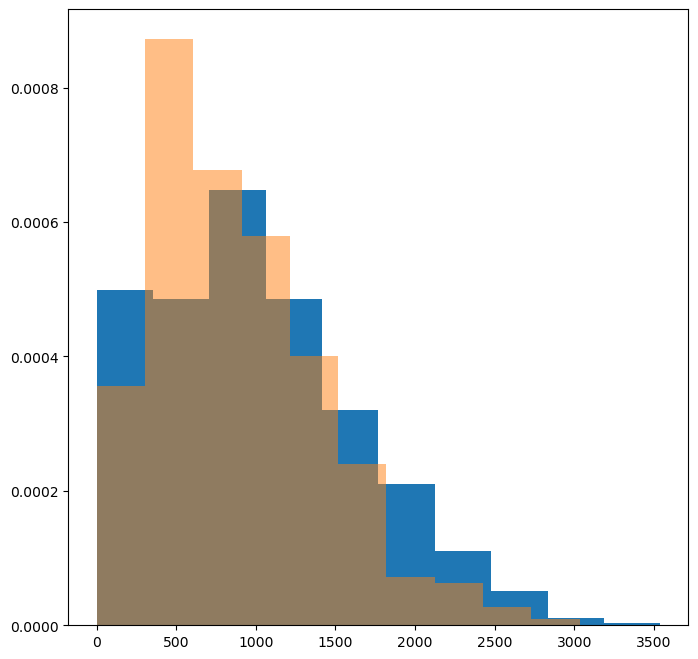

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.hist(samplewise_bool.filter(pl.col("monoallelic")==False)["Promiscuity"], color="tab:blue", density=True)
ax.hist(samplewise_bool.filter(pl.col("monoallelic")==True)["Promiscuity"], color="tab:orange", density=True, alpha=0.5)